### The problem

acidoCEST MRI has shown to be solve a valuable tool to measure pH of several tissues accurrately and with minor invasiveness.
The extraction of pH from a CEST spectra is isually done following a linear model developed by Pagel et al. However, this method has two limitations:
1. It does not consider variations in the CEST spectra that easily discernible by visual inspection or loretnzian fitting
2. It assumes a linear relationship between the features extracted from a CEST spectra and the observed pH.

In this work, we propose to address these two limitations by:
1. Using `ALL` available information in the CEST spectra as a possible predictor of pH (wiht and without dimensionality reduction)
2. Creating flexible models that do not require a linear assumption between predictors and pH

In [1]:
from tpot import TPOTRegressor
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import seaborn as sns
import numpy as np
import datetime

### Figure 1

In [2]:
# data
acidoCEST_ML = pd.read_csv('../acido_CEST_MRI_MegaBox_01_to_08_clean.csv')
acidoCEST_ML = acidoCEST_ML.drop(['Unnamed: 0','ApproT1(sec)','Temp','FILE','Conc(mM)'], axis = 1)
print(acidoCEST_ML.shape)

(36000, 89)


In [3]:
outcome_col = ['pH']

predictors = acidoCEST_ML.drop( outcome_col  + ['ExpB1(percent)'], axis=1)
outcome    = acidoCEST_ML[outcome_col]

In [4]:
for p in predictors.columns[0:6]:
    print(p, predictors[p].nunique() )

ExpT1(ms) 996
ExpT2(ms) 987
ExpB0(ppm) 996
ExpB0(Hz) 996
SatPower(uT) 6
SatTime(ms) 6


In [5]:
predictors.iloc[:,6::].shape

(36000, 81)

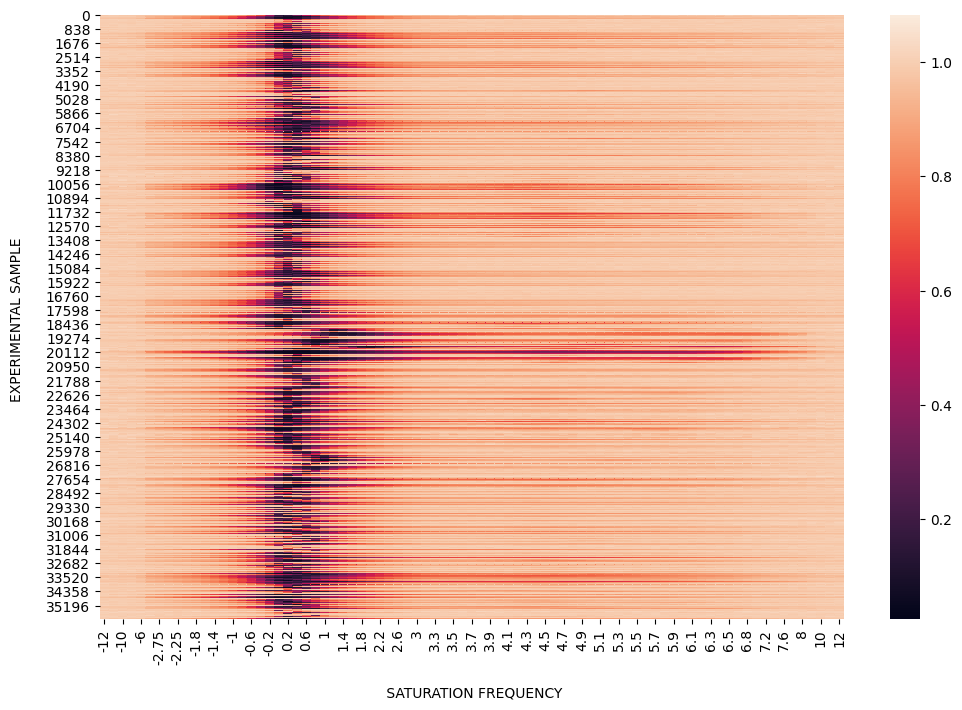

In [6]:
z = predictors.iloc[:,6::]
f,ax = plt.subplots(dpi=100, figsize=(12,8))
sns.heatmap(z,ax=ax)
plt.xlabel('\n SATURATION FREQUENCY')
plt.ylabel('EXPERIMENTAL SAMPLE \n ')
plt.savefig('CEST_heatmap.png')

## Figure 2 TPO training to get pipeline all features we can measure

In [7]:
%%time

X_train, X_test, y_train, y_test = train_test_split(  predictors
                                                    , outcome
                                                    , test_size=0.30, random_state=42)

n=2
tpot = TPOTRegressor(    generations= n, population_size= n, verbosity=2, n_jobs= 4 , cv = 3
                        , early_stop=3
                        , max_time_mins= 1
                        , template = 'StandardScaler-Transformer-Selector-Regressor'
                        , scoring = metrics.make_scorer(metrics.median_absolute_error,greater_is_better=False) )

tpot.fit(X_train,y_train)

date_time = datetime.datetime.now().strftime("%m_%d_%Y_%H:%M")
tpot.export('acidoCEST_ML_tpot_pH_regressor__all_predictors'+date_time+'.py')

print('Score on test set: \n',tpot.score(X_test, y_test))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Generation 1 - Current best internal CV score: -0.18999998210780453

Generation 2 - Current best internal CV score: -0.17999999245302822

Best pipeline: GradientBoostingRegressor(SelectFwe(OneHotEncoder(StandardScaler(input_matrix), minimum_fraction=0.05, sparse=False, threshold=10), alpha=0.04), alpha=0.8, learning_rate=1.0, loss=lad, max_depth=5, max_features=0.3, min_samples_leaf=8, min_samples_split=8, n_estimators=100, subsample=0.55)
Score on test set: 
 -0.1600000002871962
CPU times: user 23.1 s, sys: 577 ms, total: 23.7 s
Wall time: 1min 35s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
sat_powers  = X_test['SatPower(uT)'].unique().tolist(); sat_powers.sort()

sat_times = X_test['SatTime(ms)'].unique().tolist(); sat_times.sort()

E = pd.DataFrame(data = np.zeros(  ( len(sat_times) , len(sat_powers) )  )
                 , columns=sat_powers
                 , index = sat_times )

for t in sat_times:
    for p in sat_powers:
        f = (X_test['SatPower(uT)'] == p) & (X_test['SatTime(ms)']== t)
        yhat = tpot.predict(X_test[f])
        error = metrics.mean_absolute_error(y_test[f], yhat)
        E.loc[t,p] = error

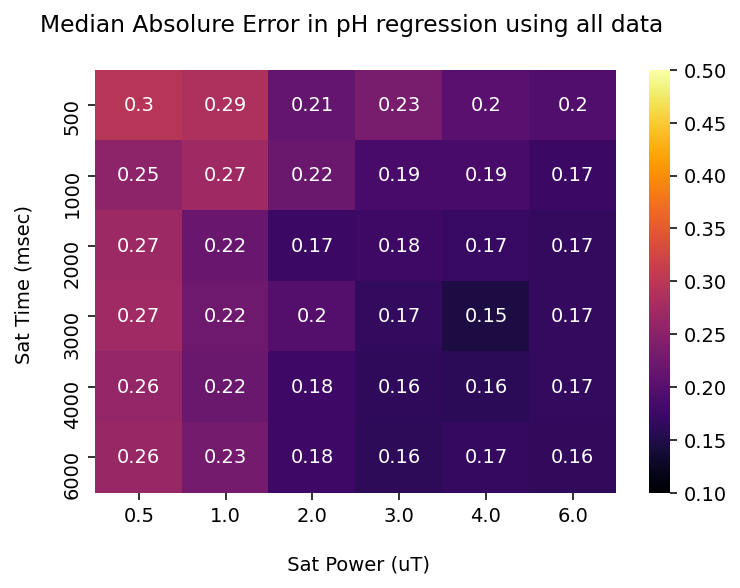

In [9]:
fig, ax = plt.subplots(dpi = 140)
sns.heatmap(E, cmap='inferno',ax = ax, vmin=.1, vmax=0.50,annot=True)
plt.xlabel('\n Sat Power (uT)')
plt.ylabel('Sat Time (msec) \n')
plt.title('Median Absolure Error in pH regression using all data \n')
plt.savefig('Figure_02.png')

## TPO training to get pipeline with `only` CEST data
- note: You cannot compare the results with the model using the entire data if the models are different

In [10]:
drop_cols = ['ExpT1(ms)','ExpT2(ms)',	'ExpB0(ppm)','ExpB0(Hz)','SatPower(uT)','SatTime(ms)']

In [ ]:
%%time

tpot2 = TPOTRegressor(    generations= n, population_size = n, verbosity=2, n_jobs= 4 , cv = 3
                        , early_stop=3
                        , max_time_mins= 1
                        , template = 'StandardScaler-Transformer-Selector-Regressor'
                        , scoring = metrics.make_scorer(metrics.median_absolute_error,greater_is_better=False) )

tpot2.fit(X_train.drop(drop_cols,axis=1),y_train)

date_time = datetime.datetime.now().strftime("%m_%d_%Y_%H:%M")
tpot2.export('acidoCEST_ML_tpot_pH_regressor_CEST_only'+date_time+'.py')

print('Score on test set: \n',tpot2.score(X_test.drop(drop_cols,axis=1), y_test))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Figure 2 comparsion of all vs only CEST

In [ ]:
fig, ax = plt.subplots(figsize=(8,4), dpi = 100)
sns.regplot(x=y_test,y=tpot2.predict(X_test.drop(drop_cols,axis=1)),ci=99,ax = ax)

sns.regplot(x=y_test,y=tpot.predict(X_test),ci=99,ax = ax)
sns.regplot(x=y_test,y= y_test,ci=99,ax = ax)

plt.legend(['only CEST data','ALL measurable data','perfect fit'])
plt.xlim([6.2,7.4])
plt.ylim([6.2,7.4])